# Introduction 


New global sensitivity measures based on quantiles of the output has been introduced by [Kucherenko et al.(2019)](https://www.sciencedirect.com/science/article/abs/pii/S0951832016304574) in which $\alpha$th quantiles are the functions of interest. 


New quantile-based sensitivity measures $\bar{q}_i^{(1)}(\alpha)$ and $\bar{q}_i^{(2)}(\alpha)$:

$$
\bar{q}_i^{(1)}(\alpha)=E_{x_i}(|q_Y(\alpha)-q_{Y \mid X_{i}}(\alpha)|) 
\tag{11}
$$

$$
\bar{q}_i^{(2)}(\alpha)=E_{x_i}[(q_Y(\alpha)-q_{Y \mid X_{i}}(\alpha))^2]
\tag{12}
$$
   
   
Normalized versions of quantile-based sensitivity measures $Q_i^{(1)}(\alpha)$ and $Q_i^{(2)}(\alpha)$:


$$
Q_i^{(1)}(\alpha)=\frac{\bar{q}_i^{(1)}(\alpha)}{\sum_{j=1}^d \bar{q}_j^{(1)}(\alpha)}
\tag{13}
$$   

$$
Q_i^{(2)}(\alpha)=\frac{\bar{q}_i^{(2)}(\alpha)}{\sum_{j=1}^d \bar{q}_j^{(2)}(\alpha)}
\tag{14}
$$

   
This notebook reproduces the numerical test results of the paper. Equation numbers and notations below are coincide
to the paper.
  

In [82]:
import numpy as np
import chaospy as cp
import matplotlib.pyplot as plt
from scipy.stats import norm,uniform,expon

# Analytical results for test 1(Section 6 & 7)

For **linear model with normally distributed variables**, analytical values of sensitivity indices can be found and used as benchmarks for verification of numerical estimates. 

### Parameters

In [12]:
# mean and covariance
mean_1 = np.array([1, 3, 5, 7])
cov_1 = np.array(
    [
        [1, 0, 0, 0],
        [0, 2.25, 0, 0],
        [0, 0, 4, 0],
        [0, 0, 0, 6.25],
    ],
)

# dimension 
dim = 4

# range of alpha
dalp = (0.98 - 0.02) / 30   # 0.032
alp = np.arange(0.02, 0.98 + dalp, dalp) 

### Objective function
$$Y=x_1+x_2+x_3+x_4$$

In [13]:
# objective function (Eq.32)
a = np.array([1, 1, 1, 1])

def objfun(x):
    result = a[0] * x[:, 0] + a[1] * x[:, 1] + a[2] * x[:, 2] + a[3] * x[:, 3]
    return result

### sobol indices

$$
S_i=S_i^{tot}=\frac{a_i^2 \sigma_i^2}{\sum_{j=1}^d a_j^2 \sigma_j^2}
$$

In [27]:
# sobol indices
S_i = []
for i in range(dim):
    S_i_i = a[0] ** 2 * cov_1[i, i] / np.trace(np.power(a, 2) * cov_1)
    S_i.append(S_i_i)

S_i = np.hstack(S_i)

print(S_i)

# for plot convinence
S_i_plot = np.tile(S_i, (len(alp), 1))

[0.07407407 0.16666667 0.2962963  0.46296296]


### Quantile-based measures
$q_i^{(2)}(\alpha)$ is obtained from following formula:

$$
q_i^{(2)}(\alpha)=a_i^2 \sigma_i^2+[\Phi^{-1}(\alpha)]^2 \left(\sqrt{\sum_{i=1}^d a_i^2 \sigma_i^2}-\sqrt{\sum_{j=1,j \ne i}^d a_j^2 \sigma_j^2} \right)^2
\tag{30}
$$

In [18]:
# inverse error function
phi_inv = norm.ppf(alp)

# q_2: PDF of the out put Y(Eq.30)
q_2 = []
for a in range(len(alp)):
    q_2_a = []
    for i in range(dim):
        q_2_i = cov_1[i,i] + phi_inv[a] ** 2 * (np.sqrt(np.trace(cov_1)) - np.sqrt(sum(cov_1[j, j] for j in range(dim) if j != i))) ** 2
        q_2_a.append(q_2_i)
    q_2.append(q_2_a)
    
q_2 = np.vstack(q_2).reshape((len(alp), dim))

In [20]:
# Q_2: normalized quantile based sensitivity measure 2.(Eq.14)
Q_2 = []
for a in range(len(alp)):
    Q_2_a = []
    for i in range(dim):
        Q_2_i = q_2[a, i] / sum(q_2[a])
        Q_2_a.append(Q_2_i)
    Q_2.append(Q_2_a)

Q_2 = np.hstack(Q_2).reshape((len(alp), dim))

### Plot

Text(0, 0.5, 'Measures')

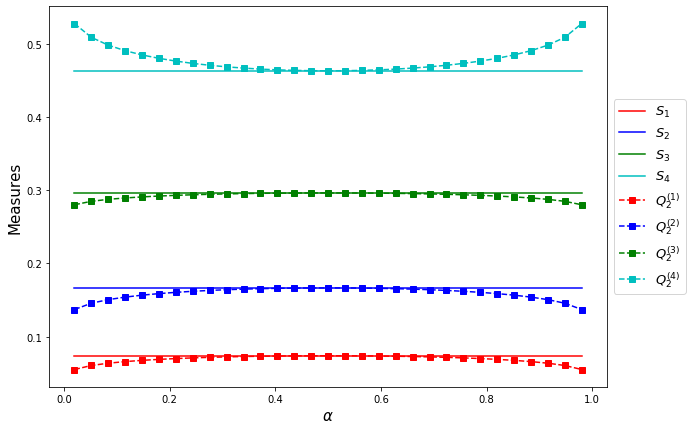

In [79]:
plt.figure(figsize=(10,7))

plt.plot(alp, S_i_plot[:, 0], 'r-',label=r'$S_1$')
plt.plot(alp, S_i_plot[:, 1], 'b-',label=r'$S_2$')
plt.plot(alp, S_i_plot[:, 2], 'g-',label=r'$S_3$')
plt.plot(alp, S_i_plot[:, 3], 'c-',label=r'$S_4$')

plt.plot(alp, Q_2[:, 0], 'rs--',label=r'$Q_2^{(1)}$')
plt.plot(alp, Q_2[:, 1], 'bs--',label=r'$Q_2^{(2)}$')
plt.plot(alp, Q_2[:, 2], 'gs--',label=r'$Q_2^{(3)}$')
plt.plot(alp, Q_2[:, 3], 'cs--',label=r'$Q_2^{(4)}$')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=13)
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("Measures",fontsize=15)

# DLR MC estimator(section 4 & 7)

## Steps
- Sampling
    - Generate sample A(N*dim) from the joint PDF
    - Get conditional sample matrix C: 
        - Sorted $A$ in ascending order with respect to the values of $A_i$ 
        - subdivided in M equally populated partitions (bins) with $N_m=N/M$ points in each bin $(M < N)$
        - within each bin $x_i$ being fixed at $x_i=X_i^l,l=1,\dots, N_m$
- get quantiles
    - _unconditional_q_Y
    - _conditional_q_Y

- get measures
    - quantile_based_measures
    - nomalized_quantile_based_measures




## MCS_quantile function

In [17]:
def MCS_quantile(N,M,alp,loc,scale,skip,dist_type):
    q1_alp, q2_alp = _quantile_based_measures(N,M,dim,alp,dist_type)
    Q1_alp, Q2_alp = _nomalized_quantile_based_measures(N,M,dim,alp,dist_type)
    
    return q1_alp, q2_alp, Q1_alp, Q2_alp


def _quantile_based_measures(N,M,dim,alp,dist_type):
    # shape(1, 4, 1, 64)
    delt=np.array([[np.zeros((1,M)) for x in range(dim)] for z in range(1)],dtype=np.float64)
    q1_alp=np.zeros((len(alp),dim))
    q2_alp=np.zeros((len(alp),dim))
    
    qy_alp1 = _unconditional_q_Y(N,M,dim,alp,dist_type)
    qy_alp2 = _conditional_q_Y(N,M,dim,alp,dist_type)
    
    for i in range(dim):
        for pp in range(len(alp)):
            delt[0,i]=qy_alp2[0,i,pp,:] - qy_alp1[pp]  # delt
            q1_alp[pp,i]=np.mean(np.absolute(delt[0,i]))  # |delt|
            q2_alp[pp,i]=np.mean(delt[0,i]**2)  # (delt)^2
            
    return q1_alp, q2_alp


def _nomalized_quantile_based_measures(N,M,dim,alp,dist_type):
    # shape(1, 31)
    q1=np.zeros(len(alp))
    q2=np.zeros(len(alp))

    Q1_alp=np.zeros((len(alp),dim))
    Q2_alp=np.zeros((len(alp),dim))
    
    q1_alp, q2_alp = _quantile_based_measures(N,M,dim,alp,dist_type)
    
    for pp in range(len(alp)):
        q1[pp]=np.sum(q1_alp[pp,:])
        q2[pp]=np.sum(q2_alp[pp,:])
        for i in range(dim):
            Q1_alp[pp,i]=q1_alp[pp,i]/q1[pp]
            Q2_alp[pp,i]=q2_alp[pp,i]/q2[pp]
    
    return Q1_alp, Q2_alp


def _unconditional_q_Y(N,M,dim, alp,dist_type):
    A  = _get_unconditional_sample(N, M, dim, skip, dist_type)
    # values of outputs
    Y1 = objfun(A)
    # reorder in ascending order
    y1 = np.sort(Y1)
    
    # q_Y(alp)
    q_index = (np.floor(alp*N)-1).astype(int)
    qy_alp1 = y1[q_index]
    
    return qy_alp1 


def _conditional_q_Y(N,M,dim,alp,dist_type):
    C  = _get_conditional_sample(N, M, dim, skip, dist_type)

    # values of conditional outputs
    # shape(8192, 4, 8192, 1)
    Y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)
    y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)
    
    # shape(1, 4, 31, 64)
    qy_alp2=np.array([[np.zeros((len(alp),M)) for x in range(dim)] for z in range(1)],dtype=np.float64)
    
    for i in range(dim):
        for j in range(M):
            Y2[j,i] = np.vstack(objfun(C[j,i]))  # values of conditional outputs
            Y2[j,i].sort(axis=0)
            y2[j,i] = Y2[j,i] # reorder in ascending order
            for pp in range(len(alp)):
                qy_alp2[0,i,pp,j]=y2[j,i][(np.floor(alp[pp]*N)-1).astype(int)] # conditioanl q_Y(alp)
    
    return qy_alp2


def _get_conditional_sample(N, M, dim, skip, dist_type):
    # conditional sample matrix C,with shape(64, 4, 8192, 4)
    A = _get_unconditional_sample(N, M, dim, skip, dist_type)
    B = A[:M]
    C = np.array([[np.zeros((N,dim)) for x in range(dim)] for z in range(M)],dtype=np.float64)  
    
    for i in range(dim):
        for j in range(M):
            C[j,i] = A
            C[j,i,:,i] = B[j, i]   
    
    return C


def _get_unconditional_sample(N, M, dim, skip, dist_type):
    
    A = np.zeros((N,dim))
    X001 = cp.generate_samples(order=N+skip, domain=dim, rule="S").T
    X01 = X001[skip:, :dim]

    if dist_type == "Normal":
        X1 = norm.ppf(X01)
        cholesky = np.linalg.cholesky(scale)
        A = loc + cholesky.dot(X1.T).T
    elif dist_type == "Exponential":
        A = expon.ppf(X01,loc,scale)
    elif dist_type == "Uniform":
        A = uniform.ppf(X01,loc,scale)

    return A

## Numerical tests

In [ ]:
# Total number of sample points
N = 2**13 # 8192

# range of alpha
dalp = (0.98-0.02)/30   # 0.032
alp = np.arange(0.02, 0.98+dalp, dalp) 

# number of conditional samples
M = 64

### Test 1: Linear function

In [18]:
# mean for normal distribution
miu = np.array([1,3,5,7])

# standard deviation for normal distribution
cov = np.array(
    [
        [1, 0, 0, 0],
        [0, 2.25, 0, 0],
        [0, 0, 4, 0],
        [0, 0, 0, 6.25],
    ],
)

# objective function
a = [1,1,1,1]
def objfun(x):
    result = a[0]*x[:,0]+a[1]*x[:,1]+a[2]*x[:,2]+a[3]*x[:,3]
    return result

# dimension of inputs
dim = np.size(miu) # 4

# distribution type
dist_type="Normal"

# sobol ship
skip=0

In [19]:
q1_alp, q2_alp, Q1_alp, Q2_alp=MCS_quantile(N,M,alp,miu,cov,skip,dist_type)

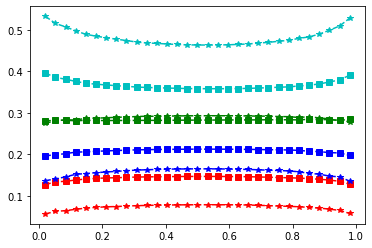

In [20]:
plt.plot(alp,Q1_alp[:,0],'rs--',alp,Q1_alp[:,1],'bs--',alp,Q1_alp[:,2],'gs--',alp,Q1_alp[:,3],'cs--')

plt.plot(alp,Q2_alp[:,0],'r*--',alp,Q2_alp[:,1],'b*--',alp,Q2_alp[:,2],'g*--',alp,Q2_alp[:,3],'c*--')

# plt.plot(alp,S_i[:,0],'r-',alp,S_i[:,1],'b-',alp,S_i[:,2],'g-',alp,S_i[:,3],'c-')

### Test 2: $Y=x_1-x_2+x_3-x_4$


In [21]:
# objective function
a = [1,-1,1,-1]
def objfun(x):
    result = a[0]*x[:,0]+a[1]*x[:,1]+a[2]*x[:,2]+a[3]*x[:,3]
    return result

# dimension of inputs
dim = np.size(a) # 4

# distribution type
dist_type="Exponential"
skip=0


loc=0
scale=1

In [22]:
q1_alp, q2_alp, Q1_alp, Q2_alp=MCS_quantile(N,M,alp,miu,cov,skip,dist_type)

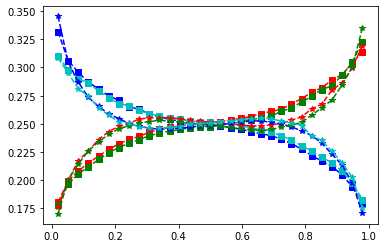

In [23]:
plt.plot(alp,Q1_alp[:,0],'rs--',alp,Q1_alp[:,1],'bs--',alp,Q1_alp[:,2],'gs--',alp,Q1_alp[:,3],'cs--')

plt.plot(alp,Q2_alp[:,0],'r*--',alp,Q2_alp[:,1],'b*--',alp,Q2_alp[:,2],'g*--',alp,Q2_alp[:,3],'c*--')

# plt.plot(alp,S_i[:,0],'r-',alp,S_i[:,1],'b-',alp,S_i[:,2],'g-',alp,S_i[:,3],'c-')

### Test 3: $Y=sin(x_1)+7(sin x_2)^2+0.1x_3^4sin(x_1)$

In [24]:
# objective function
def objfun(x):

    result = np.sin(x[:,0]) + 7 * np.sin(x[:,1])**2 + 0.1 * x[:,2]**4*np.sin(x[:,0])
    
    return result


# dimension of inputs
dim = 3 

# distribution type
dist_type="Uniform"
skip=0

# # lower bound
lower_bound=-np.pi
# # interval
interval=2*np.pi
## upper，lowerbound？

loc=lower_bound
scale=interval

In [25]:
q1_alp, q2_alp, Q1_alp, Q2_alp=MCS_quantile(N,M,alp,miu,cov,skip,dist_type)

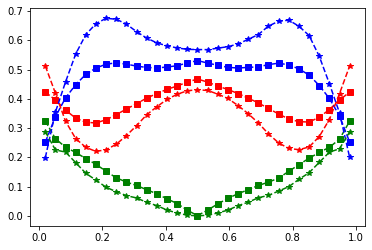

In [26]:
plt.plot(alp,Q1_alp[:,0],'rs--',alp,Q1_alp[:,1],'bs--',alp,Q1_alp[:,2],'gs--')

plt.plot(alp,Q2_alp[:,0],'r*--',alp,Q2_alp[:,1],'b*--',alp,Q2_alp[:,2],'g*--')

### Test 4: $Y=x_1 x_3+x_2 x_4$

In [27]:
miu = np.array([0, 0, 250, 400])

cov = np.array(
    [
        [16, 2.4, 0, 0],
        [2.4, 4, 0, 0],
        [0, 0, 40000, -18000],
        [0, 0, -18000, 90000],
    ],
)


def objfun(x):

    result = x[:,0]*x[:,2]+x[:,1]*x[:,3]
    
    return result


# dimension of inputs
dim = np.size(miu)

# distribution type
dist_type="Normal"
skip=0

loc=miu
scale=cov

In [28]:
q1_alp, q2_alp, Q1_alp, Q2_alp=MCS_quantile(N,M,alp,miu,cov,skip,dist_type)

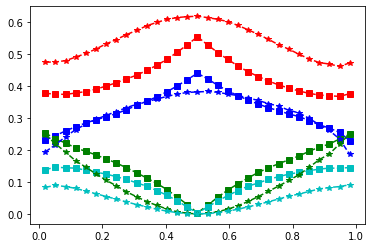

In [29]:
plt.plot(alp,Q1_alp[:,0],'rs--',alp,Q1_alp[:,1],'bs--',alp,Q1_alp[:,2],'gs--',alp,Q1_alp[:,3],'cs--')

plt.plot(alp,Q2_alp[:,0],'r*--',alp,Q2_alp[:,1],'b*--',alp,Q2_alp[:,2],'g*--',alp,Q2_alp[:,3],'c*--')